## Import Packages 


In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import random
from pathlib import Path
import pandas as pd
import os
from typing import Dict, List, Union
import requests
import logging

In [ ]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

## Data Preparation

### Data Loading

In [ ]:
data_dir = r'C:\wastenet-garbage-classifier\dataset'

In [ ]:
# Exploration
from PIL import Image
import os
 
def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0
 
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images
 
        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.add(img.size)

        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")
 
    print(f"\nTotal: {total_images}")

In [ ]:
print_images_resolution(data_dir)

battery: 945
- (178, 283)
- (315, 160)
- (243, 208)
- (225, 224)
- (200, 252)
- (201, 251)
- (223, 226)
- (357, 141)
- (187, 270)
- (168, 299)
- (276, 183)
- (324, 156)
- (254, 198)
- (259, 194)
- (280, 180)
- (347, 145)
- (266, 190)
- (267, 189)
- (252, 200)
- (272, 185)
- (257, 196)
- (258, 195)
- (287, 176)
- (220, 220)
- (168, 301)
- (247, 204)
- (213, 236)
- (279, 181)
- (284, 177)
- (270, 187)
- (400, 126)
- (299, 168)
- (256, 197)
- (377, 133)
- (343, 147)
- (290, 174)
- (245, 206)
- (291, 173)
- (246, 205)
- (262, 192)
- (251, 201)
- (164, 306)
- (309, 163)
- (269, 188)
- (298, 169)
- (301, 168)
- (260, 194)
- (244, 207)
- (249, 203)
- (250, 202)
- (233, 216)
- (180, 180)
- (234, 215)
- (281, 180)
- (451, 112)
- (200, 167)
- (345, 146)
- (293, 172)
- (318, 159)
- (231, 218)
- (248, 204)
- (232, 217)
- (169, 298)
- (312, 161)
- (325, 155)
- (456, 110)
- (322, 156)
- (235, 215)
- (236, 214)
- (310, 163)
- (200, 169)
- (188, 268)
- (314, 160)
- (224, 224)
- (327, 154)
- (271, 186)

In [ ]:
classes = os.listdir(data_dir)
print(f"Classes: {classes}")

for class_name in classes:
    num_images = len(os.listdir(os.path.join(data_dir, class_name)))
    print(f"{class_name}: {num_images} images")


Classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
battery: 945 images
biological: 985 images
brown-glass: 607 images
cardboard: 891 images
clothes: 5325 images
green-glass: 629 images
metal: 769 images
paper: 1050 images
plastic: 865 images
shoes: 1977 images
trash: 697 images
white-glass: 775 images


In [ ]:
image_dir = Path(data_dir)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

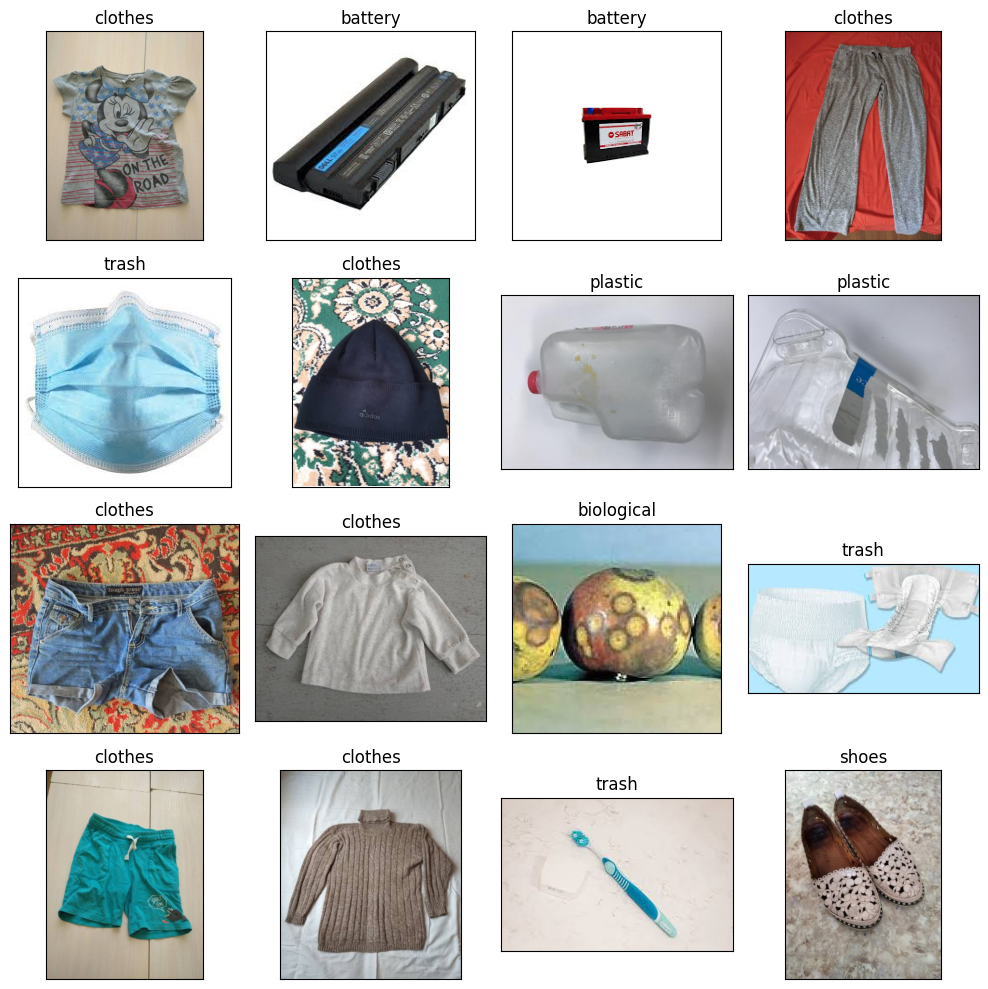

In [ ]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 20)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [ ]:
# Constants
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNEL = 3
BATCH_SIZE = 128
EPOCHS = 25

### Data Preprocessing

#### Split Dataset

In [ ]:
import shutil
import numpy as np
from sklearn.model_selection import train_test_split

# Use local working directory instead of Kaggle path
base_dir = "working"  # Local working directory
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)

# Divide for each class
for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    images = np.array(os.listdir(class_path))

    # Split data: 80% train, 10% val, 10% test
    train_images, temp_images = train_test_split(images, test_size=0.2, random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

    for split_name, split_images in zip(["train", "val", "test"], [train_images, val_images, test_images]):
        split_class_dir = os.path.join(base_dir, split_name, class_name)
        os.makedirs(split_class_dir, exist_ok=True)

        for img in split_images:
            src_path = os.path.join(class_path, img)
            dst_path = os.path.join(split_class_dir, img)
            shutil.copy(src_path, dst_path)

print("Dataset successfully divided into train, validation and test set!")

Dataset successfully divided into train, validation and test set!


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

print("Data Loaded Successfully!")


Found 12409 images belonging to 12 classes.
Found 1550 images belonging to 12 classes.
Found 1556 images belonging to 12 classes.
Data Loaded Successfully!


## Modelling

In [ ]:
base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL), include_top=False, weights='imagenet')
base_model.trainable = False

for layer in base_model.layers[:20]:
    layer.trainable = True

# Sequential Model
with tf.device('/device:GPU:0'):
    model = Sequential([
        base_model,
        Conv2D(256, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        GlobalAveragePooling2D(),
        Dropout(0.3),
        Dense(len(train_generator.class_indices), activation='softmax')
    ])


initial_learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
# Config Callbaks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [16]:
istory = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

Epoch 1/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8547 - loss: 0.4817
Epoch 1: val_accuracy improved from None to 0.62258, saving model to best_model.keras
194/194 ━━━━━━━━━━━━━━━━━━━━ 465s 2s/step - accuracy: 0.8644 - loss: 0.4446 - val_accuracy: 0.6226 - val_loss: 1.4179 - learning_rate: 0.0010
Epoch 2/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8874 - loss: 0.3618
Epoch 2: val_accuracy improved from 0.62258 to 0.63742, saving model to best_model.keras
194/194 ━━━━━━━━━━━━━━━━━━━━ 501s 3s/step - accuracy: 0.8956 - loss: 0.3346 - val_accuracy: 0.6374 - val_loss: 1.3343 - learning_rate: 0.0010
Epoch 3/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9039 - loss: 0.2897
Epoch 3: val_accuracy did not improve from 0.63742
194/194 ━━━━━━━━━━━━━━━━━━━━ 571s 3s/step - accuracy: 0.9071 - loss: 0.2899 - val_accuracy: 0.5458 - val_loss: 2.0736 - learning_rate: 0.0010
Epoch 4/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9172 - loss: 0.2449
Epoch 4:

## Evaluation of the trained model 

In [17]:
# Evaluate the model
evaluation = model.evaluate(
    test_generator,
    steps=test_generator.samples // test_generator.batch_size
)
 
print("Loss:", evaluation[0])
print("Accuracy:", evaluation[1])

c:\wastenet-garbage-classifier\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 841ms/step - accuracy: 0.9564 - loss: 0.1615
Loss: 0.16147635877132416
Accuracy: 0.9563801884651184


NameError: name 'history' is not defined

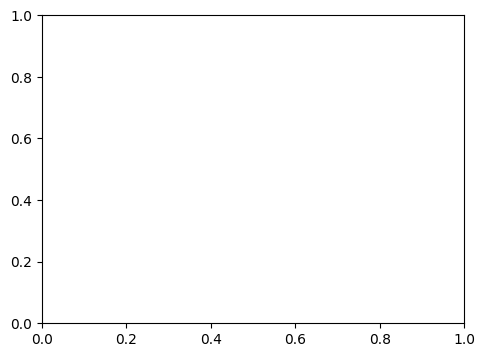

In [22]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

NameError: name 'history' is not defined

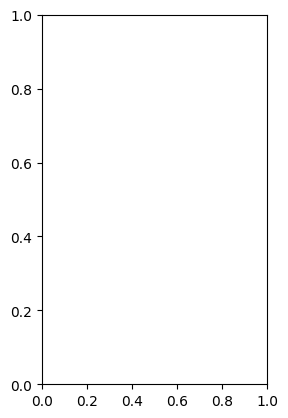

In [23]:
# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Konversi Model

In [24]:
# Save model in SavedModel format
tf.saved_model.save(model, 'models')

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets


## Inference (Optional)

## Local Prediction (No Docker Required)

This section provides functions to make predictions using the trained model locally without requiring Docker or external APIs.

In [27]:
# Load the best trained model for local inference
loaded_model = tf.keras.models.load_model('best_model.keras')

def load_and_preprocess_image_local(file_path: Union[str, Path], target_size: tuple = (224, 224)) -> np.ndarray:
    """
    Load and preprocess an image for local classification.
    
    Args:
        file_path: Path to the image file
        target_size: Tuple of (height, width) for resizing
    
    Returns:
        Preprocessed image tensor as numpy array
    """
    try:
        file_path = Path(file_path)
        if not file_path.is_file():
            raise FileNotFoundError(f"Image file not found: {file_path}")

        # Load image using PIL
        from PIL import Image
        image = Image.open(file_path)
        
        # Convert to RGB if necessary
        if image.mode != 'RGB':
            image = image.convert('RGB')
        
        # Resize image
        image = image.resize(target_size)
        
        # Convert to numpy array and normalize
        image_array = np.array(image) / 255.0
        
        # Add batch dimension
        image_tensor = np.expand_dims(image_array, axis=0)

        return image_tensor

    except Exception as e:
        print(f"Error preprocessing image: {str(e)}")
        raise

def predict_image_local(image_path: str) -> Dict[str, Union[str, float, List[Dict[str, float]]]]:
    """
    Predict image class using the loaded model locally.

    Args:
        image_path: Path to the image file

    Returns:
        Dictionary containing prediction results and confidence scores for all classes
    """
    try:
        # Preprocess image
        image_tensor = load_and_preprocess_image_local(image_path)
        
        # Make prediction
        predictions = loaded_model.predict(image_tensor, verbose=0)[0]
        predicted_class_idx = np.argmax(predictions)
        confidence = float(predictions[predicted_class_idx])
        predicted_class = LABEL_MAP[predicted_class_idx]
        
        # Create all predictions list
        all_predictions = [
            {
                'label': LABEL_MAP[idx],
                'confidence': float(score)
            }
            for idx, score in enumerate(predictions)
        ]
        
        # Sort predictions by confidence
        all_predictions.sort(key=lambda x: x['confidence'], reverse=True)
        
        return {
            'confidence_scores': predictions.tolist(),
            'predicted_class': predicted_class,
            'confidence': confidence,
            'all_predictions': all_predictions
        }
        
    except Exception as e:
        print(f"Prediction error: {str(e)}")
        raise

print("✅ Local prediction functions loaded successfully!")

✅ Local prediction functions loaded successfully!


In [ ]:
# Test local inference with the metal image
image_path = 'metal118.jpg'

try:
    result = predict_image_local(image_path)
    print(f"🔍 Testing Local Prediction")
    print(f"📁 Image: {image_path}")
    print(f"🎯 Predicted Class: {result['predicted_class']}")
    print(f"🎪 Confidence: {result['confidence']:.4f} ({result['confidence']*100:.2f}%)")
    
    print(f"\n🏆 Top 5 Predictions:")
    for i, pred in enumerate(result['all_predictions'][:5]):
        print(f"  {i+1}. {pred['label']}: {pred['confidence']:.4f} ({pred['confidence']*100:.2f}%)")
        
except FileNotFoundError:
    print(f"❌ Image file '{image_path}' not found. Please ensure the image exists in the current directory.")
except Exception as e:
    print(f"❌ Error during prediction: {str(e)}")

In [ ]:
# Install opencv if not already installed
import subprocess
import sys

try:
    import cv2
    print("✅ OpenCV already installed")
except ImportError:
    print("📦 Installing OpenCV...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "opencv-python"])
    import cv2
    print("✅ OpenCV installed successfully")

def predict_from_webcam():
    """
    Real-time prediction from webcam
    """
    print("🎥 Starting webcam prediction...")
    print("Press 'q' to quit, 'c' to capture and save prediction, 's' to take screenshot")
    
    # Initialize webcam
    cap = cv2.VideoCapture(0)
    
    if not cap.isOpened():
        print("❌ Error: Could not open webcam")
        return
    
    # Set camera resolution
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
    
    capture_count = 0
    
    # Define colors for each class (BGR format for OpenCV)
    colors = {
        'battery': (0, 255, 255),      # Yellow
        'biological': (0, 255, 0),     # Green
        'brown-glass': (19, 69, 139),  # Brown
        'cardboard': (203, 192, 255),  # Light pink
        'clothes': (255, 0, 255),      # Magenta
        'green-glass': (0, 128, 0),    # Dark green
        'metal': (128, 128, 128),      # Gray
        'paper': (255, 255, 255),      # White
        'plastic': (255, 0, 0),        # Blue
        'shoes': (0, 0, 255),          # Red
        'trash': (0, 0, 0),            # Black
        'white-glass': (255, 255, 240) # Light cyan
    }
    
    while True:
        ret, frame = cap.read()
        
        if not ret:
            print("❌ Error: Could not read frame")
            break
        
        # Create a copy for prediction
        prediction_frame = frame.copy()
        
        # Convert frame to PIL Image format for prediction
        from PIL import Image
        rgb_frame = cv2.cvtColor(prediction_frame, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(rgb_frame)
        
        # Preprocess and predict
        try:
            # Resize and normalize
            pil_image = pil_image.resize((224, 224))
            image_array = np.array(pil_image) / 255.0
            image_tensor = np.expand_dims(image_array, axis=0)
            
            # Make prediction
            predictions = loaded_model.predict(image_tensor, verbose=0)[0]
            predicted_class_idx = np.argmax(predictions)
            confidence = float(predictions[predicted_class_idx])
            predicted_class = LABEL_MAP[predicted_class_idx]
            
            # Get top 3 predictions
            top_indices = np.argsort(predictions)[::-1][:3]
            top_predictions = [
                {
                    'label': LABEL_MAP[idx],
                    'confidence': float(predictions[idx])
                }
                for idx in top_indices
            ]
            
            # Get prediction info
            color = colors.get(predicted_class, (255, 255, 255))
            
            # Draw prediction on frame
            text = f"{predicted_class}: {confidence:.2%}"
            cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 
                       0.8, color, 2, cv2.LINE_AA)
            
            # Draw confidence bar
            bar_width = int(confidence * 300)
            cv2.rectangle(frame, (10, 50), (10 + bar_width, 70), color, -1)
            cv2.rectangle(frame, (10, 50), (310, 70), (255, 255, 255), 2)
            
            # Show top 3 predictions
            y_offset = 100
            for i, pred in enumerate(top_predictions):
                pred_text = f"{i+1}. {pred['label']}: {pred['confidence']:.2%}"
                pred_color = colors.get(pred['label'], (255, 255, 255))
                cv2.putText(frame, pred_text, (10, y_offset + i*25), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, pred_color, 2)
            
        except Exception as e:
            cv2.putText(frame, f"Error: {str(e)}", (10, 30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        
        # Show instructions
        cv2.putText(frame, "Press 'q' to quit, 'c' to capture, 's' for screenshot", 
                   (10, frame.shape[0] - 20), cv2.FONT_HERSHEY_SIMPLEX, 
                   0.5, (255, 255, 255), 1)
        
        # Display frame
        cv2.imshow('Garbage Classification', frame)
        
        # Handle key presses
        key = cv2.waitKey(1) & 0xFF
        
        if key == ord('q'):
            break
        elif key == ord('c'):
            # Capture and save prediction
            capture_count += 1
            filename = f"capture_{capture_count}_{predicted_class}.jpg"
            cv2.imwrite(filename, prediction_frame)
            print(f"📸 Captured: {filename} - Predicted: {predicted_class} ({confidence:.2%})")
        elif key == ord('s'):
            # Take screenshot
            screenshot_count = capture_count + 1
            screenshot_name = f"screenshot_{screenshot_count}.jpg"
            cv2.imwrite(screenshot_name, frame)
            print(f"📷 Screenshot saved: {screenshot_name}")
    
    # Clean up
    cap.release()
    cv2.destroyAllWindows()
    print("🎥 Webcam prediction ended")

print("✅ Webcam prediction function ready!")

In [ ]:
# Run webcam prediction (uncomment to start)
# predict_from_webcam()

# Alternative: Predict from a custom image file
def predict_custom_image(file_path):
    """Quick function to predict any image file"""
    try:
        result = predict_image_local(file_path)
        print(f"🔍 Predicting: {file_path}")
        print(f"🎯 Result: {result['predicted_class']} ({result['confidence']*100:.1f}% confidence)")
        return result
    except Exception as e:
        print(f"❌ Error: {e}")
        return None

# Example: Test with your own image
# Replace 'your_image.jpg' with the path to your image
# predict_custom_image('your_image.jpg')

print("✅ Prediction functions ready to use!")
print("\n📋 Usage Instructions:")
print("1. For webcam: Uncomment and run 'predict_from_webcam()'")
print("2. For custom image: Use 'predict_custom_image('path/to/your/image.jpg')'")
print("3. For the test image: The cell above already tested 'metal118.jpg'")

In [ ]:
# Interactive Garbage Classification UI
import os
import glob
from IPython.display import display, Image as IPImage, HTML, clear_output
import ipywidgets as widgets
from PIL import Image
import io
import base64

def create_prediction_ui():
    """
    Create an interactive UI for garbage classification with multiple input options
    """
    # Load model if not already loaded
    global loaded_model
    try:
        if 'loaded_model' not in globals():
            loaded_model = tf.keras.models.load_model('best_model.keras')
        print("✅ Model loaded successfully!")
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return
    
    # Create UI widgets
    title = widgets.HTML("<h2>🗑️ Garbage Classification System</h2>")
    
    # Input method selection
    method_dropdown = widgets.Dropdown(
        options=[
            ('📁 Upload Image File', 'upload'),
            ('📂 Select from Directory', 'directory'),
            ('🎥 Use Webcam', 'webcam'),
            ('🖼️ Enter Image Path', 'path'),
            ('📋 Batch Process Directory', 'batch')
        ],
        value='upload',
        description='Input Method:'
    )
    
    # File upload widget
    file_upload = widgets.FileUpload(
        accept='.jpg,.jpeg,.png,.bmp,.tiff,.webp',
        multiple=False,
        description='Upload Image'
    )
    
    # Directory browser
    directory_path = widgets.Text(
        value='.',
        description='Directory:',
        placeholder='Enter directory path'
    )
    
    # Image path input
    image_path_input = widgets.Text(
        value='metal118.jpg',
        description='Image Path:',
        placeholder='Enter image file path'
    )
    
    # Batch directory input
    batch_directory = widgets.Text(
        value='.',
        description='Batch Dir:',
        placeholder='Directory containing images'
    )
    
    # Prediction button
    predict_button = widgets.Button(
        description='🔍 Predict',
        button_style='primary',
        tooltip='Click to make prediction'
    )
    
    # Webcam button
    webcam_button = widgets.Button(
        description='🎥 Start Webcam',
        button_style='info',
        tooltip='Start webcam prediction'
    )
    
    # Output area
    output_area = widgets.Output()
    
    # Results display
    results_html = widgets.HTML()
    
    def update_input_widgets():
        """Update visible input widgets based on selected method"""
        method = method_dropdown.value
        
        # Hide all input widgets first
        file_upload.layout.display = 'none'
        directory_path.layout.display = 'none'
        image_path_input.layout.display = 'none'
        batch_directory.layout.display = 'none'
        predict_button.layout.display = 'none'
        webcam_button.layout.display = 'none'
        
        # Show relevant widgets
        if method == 'upload':
            file_upload.layout.display = 'block'
            predict_button.layout.display = 'block'
        elif method == 'directory':
            directory_path.layout.display = 'block'
            predict_button.layout.display = 'block'
        elif method == 'webcam':
            webcam_button.layout.display = 'block'
        elif method == 'path':
            image_path_input.layout.display = 'block'
            predict_button.layout.display = 'block'
        elif method == 'batch':
            batch_directory.layout.display = 'block'
            predict_button.layout.display = 'block'
    
    def predict_uploaded_image(uploaded_file):
        """Predict from uploaded file"""
        try:
            # Get the uploaded file content
            file_content = uploaded_file['content']
            file_name = uploaded_file['name']
            
            # Convert to PIL Image
            image = Image.open(io.BytesIO(file_content))
            
            # Make prediction
            result = predict_image_from_pil(image)
            
            # Display image and results
            display_prediction_results(image, result, file_name)
            
        except Exception as e:
            results_html.value = f"<div style='color: red;'>❌ Error: {str(e)}</div>"
    
    def predict_image_from_pil(pil_image):
        """Predict from PIL Image"""
        try:
            # Preprocess image
            if pil_image.mode != 'RGB':
                pil_image = pil_image.convert('RGB')
            
            # Resize and normalize
            pil_image = pil_image.resize((224, 224))
            image_array = np.array(pil_image) / 255.0
            image_tensor = np.expand_dims(image_array, axis=0)
            
            # Make prediction
            predictions = loaded_model.predict(image_tensor, verbose=0)[0]
            predicted_class_idx = np.argmax(predictions)
            confidence = float(predictions[predicted_class_idx])
            predicted_class = LABEL_MAP[predicted_class_idx]
            
            # Get top 5 predictions
            top_indices = np.argsort(predictions)[::-1][:5]
            top_predictions = [
                {
                    'label': LABEL_MAP[idx],
                    'confidence': float(predictions[idx])
                }
                for idx in top_indices
            ]
            
            return {
                'predicted_class': predicted_class,
                'confidence': confidence,
                'top_predictions': top_predictions,
                'all_scores': predictions.tolist()
            }
            
        except Exception as e:
            raise Exception(f"Prediction error: {str(e)}")
    
    def display_prediction_results(image, result, filename="Image"):
        """Display image and prediction results"""
        try:
            # Convert image to base64 for display
            img_buffer = io.BytesIO()
            image.save(img_buffer, format='PNG')
            img_str = base64.b64encode(img_buffer.getvalue()).decode()
            
            # Create HTML for results
            html_content = f"""
            <div style='border: 2px solid #ddd; padding: 20px; margin: 10px; border-radius: 10px;'>
                <h3>📊 Prediction Results for: {filename}</h3>
                
                <div style='display: flex; align-items: flex-start; gap: 20px;'>
                    <div>
                        <img src='data:image/png;base64,{img_str}' style='max-width: 300px; border-radius: 8px;'>
                    </div>
                    
                    <div style='flex: 1;'>
                        <h4>🎯 Main Prediction</h4>
                        <div style='background: #e8f5e8; padding: 15px; border-radius: 8px; margin-bottom: 15px;'>
                            <h3 style='color: #2e7d32; margin: 0;'>{result['predicted_class'].upper()}</h3>
                            <p style='font-size: 18px; margin: 5px 0;'>Confidence: <strong>{result['confidence']*100:.2f}%</strong></p>
                        </div>
                        
                        <h4>🏆 Top 5 Predictions</h4>
                        <div style='background: #f5f5f5; padding: 15px; border-radius: 8px;'>
            """
            
            # Add top predictions
            for i, pred in enumerate(result['top_predictions']):
                confidence_pct = pred['confidence'] * 100
                bar_width = max(10, confidence_pct)  # Minimum 10% width for visibility
                
                # Color coding based on confidence
                if confidence_pct >= 70:
                    color = '#4caf50'  # Green
                elif confidence_pct >= 40:
                    color = '#ff9800'  # Orange
                else:
                    color = '#f44336'  # Red
                
                html_content += f"""
                <div style='margin-bottom: 10px;'>
                    <div style='display: flex; justify-content: space-between; align-items: center;'>
                        <span><strong>{i+1}. {pred['label']}</strong></span>
                        <span><strong>{confidence_pct:.2f}%</strong></span>
                    </div>
                    <div style='background: #ddd; height: 20px; border-radius: 10px; overflow: hidden; margin-top: 5px;'>
                        <div style='background: {color}; height: 100%; width: {bar_width}%; border-radius: 10px;'></div>
                    </div>
                </div>
                """
            
            html_content += """
                        </div>
                    </div>
                </div>
            </div>
            """
            
            results_html.value = html_content
            
        except Exception as e:
            results_html.value = f"<div style='color: red;'>❌ Error displaying results: {str(e)}</div>"
    
    def browse_directory():
        """Browse and select image from directory"""
        try:
            dir_path = directory_path.value or '.'
            if not os.path.exists(dir_path):
                results_html.value = f"<div style='color: red;'>❌ Directory not found: {dir_path}</div>"
                return
            
            # Find image files
            image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff', '*.webp']
            image_files = []
            for ext in image_extensions:
                image_files.extend(glob.glob(os.path.join(dir_path, ext)))
                image_files.extend(glob.glob(os.path.join(dir_path, ext.upper())))
            
            if not image_files:
                results_html.value = f"<div style='color: orange;'>⚠️ No image files found in: {dir_path}</div>"
                return
            
            # Create dropdown for image selection
            image_dropdown = widgets.Dropdown(
                options=[(os.path.basename(f), f) for f in sorted(image_files)],
                description='Select Image:'
            )
            
            select_button = widgets.Button(description='Select & Predict', button_style='success')
            
            def on_select_click(b):
                selected_file = image_dropdown.value
                predict_from_file_path(selected_file)
            
            select_button.on_click(on_select_click)
            
            with output_area:
                clear_output()
                print(f"Found {len(image_files)} images in {dir_path}")
                display(image_dropdown, select_button)
            
        except Exception as e:
            results_html.value = f"<div style='color: red;'>❌ Error browsing directory: {str(e)}</div>"
    
    def predict_from_file_path(file_path):
        """Predict from file path"""
        try:
            if not os.path.exists(file_path):
                results_html.value = f"<div style='color: red;'>❌ File not found: {file_path}</div>"
                return
            
            # Load and predict
            image = Image.open(file_path)
            result = predict_image_from_pil(image)
            display_prediction_results(image, result, os.path.basename(file_path))
            
        except Exception as e:
            results_html.value = f"<div style='color: red;'>❌ Error: {str(e)}</div>"
    
    def batch_process_directory():
        """Process all images in a directory"""
        try:
            dir_path = batch_directory.value or '.'
            if not os.path.exists(dir_path):
                results_html.value = f"<div style='color: red;'>❌ Directory not found: {dir_path}</div>"
                return
            
            # Find image files
            image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff', '*.webp']
            image_files = []
            for ext in image_extensions:
                image_files.extend(glob.glob(os.path.join(dir_path, ext)))
                image_files.extend(glob.glob(os.path.join(dir_path, ext.upper())))
            
            if not image_files:
                results_html.value = f"<div style='color: orange;'>⚠️ No image files found in: {dir_path}</div>"
                return
            
            # Process all images
            results = []
            html_content = f"<h3>📁 Batch Processing Results ({len(image_files)} images)</h3>"\n            
            for i, file_path in enumerate(image_files[:20]):  # Limit to first 20 for performance
                try:
                    image = Image.open(file_path)
                    result = predict_image_from_pil(image)
                    results.append({
                        'file': os.path.basename(file_path),
                        'prediction': result['predicted_class'],
                        'confidence': result['confidence']
                    })
                    
                    # Add to HTML
                    confidence_pct = result['confidence'] * 100
                    color = '#4caf50' if confidence_pct >= 70 else '#ff9800' if confidence_pct >= 40 else '#f44336'
                    
                    html_content += f"""
                    <div style='border: 1px solid #ddd; margin: 5px; padding: 10px; border-radius: 5px;'>
                        <strong>{os.path.basename(file_path)}</strong> → 
                        <span style='color: {color}; font-weight: bold;'>{result['predicted_class']}</span>
                        ({confidence_pct:.1f}%)
                    </div>
                    """
                    
                except Exception as e:
                    html_content += f"""
                    <div style='border: 1px solid #f44336; margin: 5px; padding: 10px; border-radius: 5px; background: #ffebee;'>
                        <strong>{os.path.basename(file_path)}</strong> → <span style='color: red;'>Error: {str(e)}</span>
                    </div>
                    """
            
            # Summary
            if results:
                class_counts = {}
                for r in results:
                    class_counts[r['prediction']] = class_counts.get(r['prediction'], 0) + 1
                
                html_content += "<h4>📊 Summary:</h4><ul>"
                for class_name, count in sorted(class_counts.items()):
                    html_content += f"<li><strong>{class_name}</strong>: {count} files</li>"
                html_content += "</ul>"
            
            results_html.value = html_content
            
        except Exception as e:
            results_html.value = f"<div style='color: red;'>❌ Error in batch processing: {str(e)}</div>"
    
    def on_predict_click(b):
        """Handle predict button click"""
        method = method_dropdown.value
        
        if method == 'upload':
            if file_upload.value:
                uploaded_file = list(file_upload.value.values())[0]
                predict_uploaded_image(uploaded_file)
            else:
                results_html.value = "<div style='color: orange;'>⚠️ Please upload an image first</div>"
        
        elif method == 'directory':
            browse_directory()
        
        elif method == 'path':
            file_path = image_path_input.value
            if file_path:
                predict_from_file_path(file_path)
            else:
                results_html.value = "<div style='color: orange;'>⚠️ Please enter an image path</div>"
        
        elif method == 'batch':
            batch_process_directory()
    
    def on_webcam_click(b):
        """Handle webcam button click"""
        results_html.value = """
        <div style='background: #e3f2fd; padding: 15px; border-radius: 8px; margin: 10px 0;'>
            <h4>🎥 Webcam Instructions</h4>
            <p>To use webcam prediction, run this in a separate cell:</p>
            <code style='background: #f5f5f5; padding: 5px; border-radius: 3px;'>predict_from_webcam()</code>
            <p>Or use the standalone script:</p>
            <code style='background: #f5f5f5; padding: 5px; border-radius: 3px;'>
            python predict_garbage.py --mode webcam
            </code>
        </div>
        """
    
    # Connect event handlers
    method_dropdown.observe(lambda change: update_input_widgets(), names='value')
    predict_button.on_click(on_predict_click)
    webcam_button.on_click(on_webcam_click)
    
    # Initial setup
    update_input_widgets()
    
    # Create layout
    ui_layout = widgets.VBox([
        title,
        method_dropdown,
        file_upload,
        directory_path,
        image_path_input,
        batch_directory,
        widgets.HBox([predict_button, webcam_button]),
        output_area,
        results_html
    ])
    
    return ui_layout

# Create and display the UI
try:
    ui = create_prediction_ui()
    display(ui)
except Exception as e:
    print(f"❌ Error creating UI: {e}")
    print("Installing required packages...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ipywidgets"])
    print("Please restart the kernel and run this cell again.")

In [ ]:
# Simple Text-Based Prediction Interface (Alternative)
def simple_prediction_interface():
    """
    Simple text-based interface for garbage classification
    """
    # Load model if not already loaded
    try:
        if 'loaded_model' not in globals():
            loaded_model = tf.keras.models.load_model('best_model.keras')
        print("✅ Model loaded successfully!")
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return
    
    def predict_and_display(image_path):
        """Simple prediction with display"""
        try:
            if not os.path.exists(image_path):
                print(f"❌ File not found: {image_path}")
                return
            
            # Load and predict
            image = Image.open(image_path)
            if image.mode != 'RGB':
                image = image.convert('RGB')
            
            # Preprocess
            image_resized = image.resize((224, 224))
            image_array = np.array(image_resized) / 255.0
            image_tensor = np.expand_dims(image_array, axis=0)
            
            # Predict
            predictions = loaded_model.predict(image_tensor, verbose=0)[0]
            predicted_class_idx = np.argmax(predictions)
            confidence = float(predictions[predicted_class_idx])
            predicted_class = LABEL_MAP[predicted_class_idx]
            
            # Get top 5
            top_indices = np.argsort(predictions)[::-1][:5]
            
            # Display results
            print(f"\\n{'='*50}")
            print(f"📁 IMAGE: {os.path.basename(image_path)}")
            print(f"{'='*50}")
            print(f"🎯 PREDICTION: {predicted_class.upper()}")
            print(f"🎪 CONFIDENCE: {confidence*100:.2f}%")
            print(f"\\n🏆 TOP 5 PREDICTIONS:")
            print(f"{'-'*30}")
            
            for i, idx in enumerate(top_indices):
                label = LABEL_MAP[idx]
                conf = predictions[idx] * 100
                bar = '█' * int(conf/5)  # Visual bar
                print(f"{i+1}. {label:<12} {conf:5.2f}% {bar}")
            
            print(f"{'='*50}\\n")
            
            # Display image
            plt.figure(figsize=(8, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(image)
            plt.title(f"Original Image\\n{os.path.basename(image_path)}")
            plt.axis('off')
            
            # Prediction bar chart
            plt.subplot(1, 2, 2)
            top_labels = [LABEL_MAP[idx] for idx in top_indices]
            top_confs = [predictions[idx] * 100 for idx in top_indices]
            
            colors = plt.cm.RdYlGn([conf/100 for conf in top_confs])
            bars = plt.barh(range(len(top_labels)), top_confs, color=colors)
            plt.yticks(range(len(top_labels)), top_labels)
            plt.xlabel('Confidence (%)')
            plt.title('Top 5 Predictions')
            plt.gca().invert_yaxis()
            
            # Add confidence text on bars
            for i, (bar, conf) in enumerate(zip(bars, top_confs)):
                plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
                        f'{conf:.1f}%', va='center')
            
            plt.tight_layout()
            plt.show()
            
            return {
                'predicted_class': predicted_class,
                'confidence': confidence,
                'all_predictions': list(zip(top_labels, top_confs))
            }
            
        except Exception as e:
            print(f"❌ Error: {str(e)}")
            return None
    
    print("🗑️ GARBAGE CLASSIFICATION - SIMPLE INTERFACE")
    print("=" * 50)
    print("Available functions:")
    print("1. predict_and_display('path/to/image.jpg') - Predict single image")
    print("2. Available test images:")
    
    # List available images
    test_images = []
    for ext in ['*.jpg', '*.jpeg', '*.png']:
        test_images.extend(glob.glob(ext))
    
    if test_images:
        for i, img in enumerate(test_images[:10]):  # Show first 10
            print(f"   - {img}")
        if len(test_images) > 10:
            print(f"   ... and {len(test_images) - 10} more")
    else:
        print("   - No images found in current directory")
    
    print("\\n📋 Example usage:")
    print("   predict_and_display('metal118.jpg')")
    print("   predict_and_display('your_image.jpg')")
    
    # Return the function for use
    return predict_and_display

# Initialize simple interface
predict_and_display = simple_prediction_interface()

print("\\n✅ Simple prediction interface ready!")

In [ ]:
# 🎯 DEMO: Test the prediction system
print("🚀 GARBAGE CLASSIFICATION DEMO")
print("=" * 40)

# Test with the metal image if it exists
if os.path.exists('metal118.jpg'):
    print("📝 Testing with metal118.jpg...")
    result = predict_and_display('metal118.jpg')
else:
    print("⚠️ metal118.jpg not found. You can test with any image file.")
    print("\\n📋 To test with your own image:")
    print("   predict_and_display('path/to/your/image.jpg')")

In [25]:
# Logging Config
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Label Constants
LABEL_MAP = {
    0: 'battery',
    1: 'biological',
    2: 'brown-glass',
    3: 'cardboard',
    4: 'clothes',
    5: 'green-glass',
    6: 'metal',
    7: 'paper',
    8: 'plastic',
    9: 'shoes',
    10: 'trash',
    11: 'white-glass'
}

def load_and_preprocess_image(file_path: Union[str, Path], target_size: tuple = (224, 224)) -> List[List[List[List[float]]]]:
    """
    Load and preprocess an image for classification.
    
    Args:
        file_path: Path to the image file
        target_size: Tuple of (height, width) for resizing
    
    Returns:
        Preprocessed image tensor as a nested list
    """
    try:
        file_path = Path(file_path)
        if not file_path.is_file():
            raise FileNotFoundError(f"Image file not found: {file_path}")
            
        with open(file_path, 'rb') as f:
            image = tf.io.decode_image(f.read(), channels=3)
            
        image = tf.image.resize(image, target_size)
        image = image / 255.0
        image_tensor = tf.expand_dims(image, 0)
        
        return image_tensor.numpy().tolist()
        
    except Exception as e:
        logger.error(f"Error preprocessing image: {str(e)}")
        raise

def predict_image(image_tensor: List[List[List[List[float]]]], endpoint: str) -> Dict[str, Union[str, float, List[Dict[str, float]]]]:
    """
    Send image to classification endpoint and get predictions.
    
    Args:
        image_tensor: Preprocessed image tensor
        endpoint: URL of the classification API endpoint
    
    Returns:
        Dictionary containing:
        - confidence_scores: Raw prediction scores
        - predicted_class: The class with highest confidence
        - all_predictions: List of all classes with their confidence scores
    """
    try:
        request_data = {"instances": image_tensor}
        response = requests.post(endpoint, json=request_data)
        response.raise_for_status()
        
        predictions = response.json()['predictions'][0]
        predicted_class_idx = tf.argmax(predictions).numpy()
        
        all_predictions = [
            {
                'label': LABEL_MAP[idx],
                'confidence': float(score)
            }
            for idx, score in enumerate(predictions)
        ]
        
        # Sort predictions by confidence
        all_predictions.sort(key=lambda x: x['confidence'], reverse=True)
        
        return {
            'confidence_scores': predictions,
            'predicted_class': LABEL_MAP[predicted_class_idx],
            'all_predictions': all_predictions
        }
        
    except Exception as e:
        logger.error(f"Prediction error: {str(e)}")
        raise

def process_and_predict(image_path: str, endpoint: str) -> Dict[str, Union[str, float, List[Dict[str, float]]]]:
    """
    Process an image and get predictions in one step.
    
    Args:
        image_path: Path to the image file
        endpoint: URL of the classification API endpoint
    
    Returns:
        Dictionary containing prediction results and confidence scores for all classes
    """
    logger.info(f"Processing image: {image_path}")
    image_tensor = load_and_preprocess_image(image_path)
    
    logger.info("Getting predictions...")
    result = predict_image(image_tensor, endpoint)
    
    logger.info(f"Predicted class: {result['predicted_class']}")
    return result

In [26]:
image_path = 'metal118.jpg'
endpoint = "http://localhost:8501/v1/models/garbage_classifier:predict"

try:
    result = process_and_predict(image_path, endpoint)
    print(f"\nTop prediction: {result['predicted_class']}")
    print("\nAll predictions sorted by confidence:")
    for pred in result['all_predictions']:
        print(f"{pred['label']}: {pred['confidence']:.6f}")
    print(f"\nAll Confidence Score:\n{result['confidence_scores']}")
except Exception as e:
    logger.error(f"Process failed: {str(e)}")

ERROR:__main__:Prediction error: HTTPConnectionPool(host='localhost', port=8501): Max retries exceeded with url: /v1/models/garbage_classifier:predict (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001988380CD90>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))
ERROR:__main__:Process failed: HTTPConnectionPool(host='localhost', port=8501): Max retries exceeded with url: /v1/models/garbage_classifier:predict (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001988380CD90>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))
